
1. **`heapq`** → **Gestion des files de priorité (tas binaire)**  
   - Permet d’implémenter des files d’attente avec priorité en temps efficace (logarithmique).  
   - Utile pour gérer des files de requêtes triées par priorité (par exemple, un routeur FIFO).  

2. **`numpy`** → **Calculs numériques et génération de données**  
   - Fournit des outils pour les tableaux, les nombres aléatoires, les distributions probabilistes, etc.  
   - Probablement utilisé pour simuler les arrivées de requêtes (loi exponentielle) et les temps de service.  

3. **`matplotlib.pyplot`** → **Visualisation des résultats**  
   - Permet de tracer des courbes et des graphiques.  
   - Probablement utilisé pour afficher le temps de réponse et le taux de perte en fonction de \( \lambda \).  


In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt


### 1️⃣ **Nombre de serveurs et taille de la file d'attente**  
```python
N_SERVEURS = 12
QUEUE_SIZE = 100
```
- **`N_SERVEURS = 12`** : Il y a **12 serveurs** disponibles dans la ferme.  
- **`QUEUE_SIZE = 100`** : Le **routeur peut stocker jusqu'à 100 requêtes** (y compris celle en cours de traitement).  

---

### 2️⃣ **Configuration des regroupements de serveurs**  
```python
C_VALUES = [1, 2, 3, 6]
```
- La ferme est divisée en **C groupes de serveurs**, où \( C \) peut prendre **les valeurs {1, 2, 3, 6}**.  
- Comme précisé dans l’énoncé, chaque groupe est spécialisé pour un type de requête.  
- On a donc :  
  - **C = 1** → Aucun regroupement, tous les serveurs sont généralistes.  
  - **C = 2** → 2 groupes de 6 serveurs.  
  - **C = 3** → 3 groupes de 4 serveurs.  
  - **C = 6** → 6 groupes de 2 serveurs.  

---

### 3️⃣ **Valeurs de λ  à tester**  
```python
LAMBDA_VALUES = np.linspace(0.1, 2, 10)  # Valeurs initiales
LAMBDA_VALUES = np.linspace(0.1, 10, 15)  # Nouvelle plage plus large
```
- **λ ** représente le **taux d’arrivée des requêtes** (loi exponentielle).  
- **`np.linspace(0.1, 10, 15)`** génère **15 valeurs de λ ** allant de **0.1 à 10**.  
- Ceci permet d’analyser **l’impact du trafic sur la ferme de serveurs**.  

---

### 4️⃣ **Durée de simulation et intervalle de confiance**  
```python
SIMULATION_TIME = 10000  # Temps total de simulation
CONFIDENCE_LEVEL = 1.96  # Intervalle de confiance à 95%
```
- **`SIMULATION_TIME = 10000`** → La simulation dure **10 000 unités de temps**.  
- **`CONFIDENCE_LEVEL = 1.96`** → Correspond à **un intervalle de confiance de 95%** pour les mesures statistiques (temps de réponse, taux de perte, etc.).  



In [2]:
# Paramètres globaux
N_SERVEURS = 12
QUEUE_SIZE = 100
C_VALUES = [1, 2, 3, 6]
LAMBDA_VALUES = np.linspace(0.1, 2, 10)  # Valeurs de lambda à tester
#LAMBDA_VALUES = np.linspace(0.1, 10, 15)  # Augmenter la plage des valeurs de λ

SIMULATION_TIME = 10000  # Temps total de simulation
CONFIDENCE_LEVEL = 1.96  # Intervalle de confiance à 95%

### **Générer une variable aléatoire suivant une loi exponentielle de paramètre λ .**




In [3]:
# Génération de variables exponentielles
def exp_rnd(lmbda):
    return np.random.exponential(1/lmbda)



## **🟢 Modélisation des composants**  

### **1️⃣ Requête (`Requete`)**  
Une requête représente une **demande de traitement**.  
- **Elle possède :**  
  - Un **temps d'arrivée** (`time`) qui indique quand elle entre dans le système.  
  - Une **catégorie** (`category`), utilisée pour **diriger** la requête vers le bon serveur spécialisé.  

---

### **2️⃣ Serveur (`Serveur`)**  
Un serveur est une **machine qui traite une requête**.  
- **Il possède :**  
  - Un état (`busy`) : **Occupé (`True`)** ou **Libre (`False`)**.  
  - Un **temps de fin de traitement** (`end_time`) qui indique quand il sera disponible.  

Les serveurs **n'ont pas de file d'attente**, donc une requête ne peut être traitée **que si un serveur est libre**.

---

### **3️⃣ Routeur (`Routeur`)**  
Le **routeur** est responsable de la **gestion des requêtes et de leur distribution** aux serveurs.  
- **Il possède :**  
  - Une **file d'attente FIFO** (`queue`), de taille limitée (`100 requêtes max`).  
  - Un **nombre de groupes de serveurs (`C`)**, qui détermine la spécialisation.  
  - Un **ensemble de serveurs spécialisés**, regroupés par catégories.  
  - Un compteur de **requêtes perdues** (`loss_count`), lorsque la file d’attente est pleine.  

Le **nombre de groupes `C`** détermine **comment les serveurs sont organisés** :
- Si `C = 1`, **tous les serveurs sont généralistes**.  
- Si `C = 6`, **chaque groupe de serveurs traite un type de requête spécifique**.  

---

## **🟢 Fonctionnement des requêtes**  

### **1️⃣ Réception des requêtes**  
Lorsqu'une requête **arrive dans le routeur** :
- **Si la file d’attente n’est pas pleine** → Elle est **ajoutée à la file**.  
- **Si la file d’attente est pleine** → Elle est **perdue** (`loss_count` augmente).  
- Un **événement est programmé** pour **router la requête** après un délai de `(C-1)/C` (simulation du temps de routage).  

---

### **2️⃣ Routage des requêtes**  
Lorsque le **routeur traite une requête** :  
- Il détermine **à quel groupe de serveurs elle doit être envoyée** (`category % C`).  
- Il cherche **un serveur libre** dans ce groupe.  
- **Si un serveur est disponible** 🟢 → Il lui attribue la requête et **calcule un temps de traitement** (selon une loi exponentielle).  
- **Si aucun serveur n'est libre** 🔴 → La requête **reste dans la file d’attente**.  

Le **temps de traitement** dépend de `C` :
- **C = 1** → Temps moyen de service = `4/20`
- **C = 2** → Temps moyen de service = `7/20`
- **C = 3** → Temps moyen de service = `10/20`
- **C = 6** → Temps moyen de service = `14/20`  

Plus `C` est **grand**, plus les serveurs sont **spécialisés**, et donc **plus rapides**.

---

### **3️⃣ Fin de traitement et libération du serveur**  
Lorsque **le temps de service d’une requête se termine** :
- Le serveur est **libéré** (`busy = False`).  
- Si la file d’attente **n'est pas vide**, le routeur **tente immédiatement** de traiter une autre requête.  

---

## **🟢 Résumé du fonctionnement**  
1️⃣ Une **requête arrive** dans le routeur.  
2️⃣ **Si la file est pleine** → Elle est **perdue**. Sinon, elle est mise en file d’attente.  
3️⃣ **Le routeur cherche un serveur libre** pour traiter la requête.  
4️⃣ **Si un serveur est disponible** → Il traite la requête pendant un temps donné.  
5️⃣ **Quand le traitement est terminé**, le serveur est **libéré** et une autre requête peut être traitée.  

💡 **Ce système permet d’analyser comment organiser les serveurs (`C`) pour minimiser le temps de réponse et limiter les pertes.** 🚀

In [4]:
class Requete:
    def __init__(self, time, category):
        self.time = time  # Temps d'arrivée
        self.category = category  # Catégorie de la requête

class Serveur:
    def __init__(self):
        self.busy = False
        self.end_time = 0

class Routeur:
    def __init__(self, C):
        self.queue = []  # File d'attente FIFO
        self.capacity = QUEUE_SIZE
        self.C = C  # Nombre de groupes
        self.servers = {i: [Serveur() for _ in range(N_SERVEURS // C)] for i in range(C)}
        self.loss_count = 0  # Nombre de requêtes perdues

    def receive_request(self, event_queue, current_time, request):
        if len(self.queue) < self.capacity:
            self.queue.append(request)
            heapq.heappush(event_queue, (current_time + (self.C - 1) / self.C, 'route_request'))
        else:
            self.loss_count += 1  # Requête perdue

    def route_request(self, event_queue, current_time):
        if self.queue:
            request = self.queue.pop(0)
            group = request.category % self.C
            servers = self.servers[group]
            
            for server in servers:
                if not server.busy:
                    server.busy = True
                    service_time = exp_rnd({1: 4/20, 2: 7/20, 3: 10/20, 6: 14/20}[self.C])
                    server.end_time = current_time + service_time
                    heapq.heappush(event_queue, (server.end_time, 'end_service', server, group))
                    return
            
            self.queue.insert(0, request)  # Remet la requête si aucun serveur libre

    def end_service(self, event_queue, current_time, server, group):
        server.busy = False
        if self.queue:
            self.route_request(event_queue, current_time)

NOUVEAU CODE AJOUTER APRES TD DU 28/03/2025

In [5]:
def moyenne(data):
    """ calcule la moyenne de la liste data """
    return sum(data) / len(data)

def variance(data):
    """ calcule la variance de la liste data """
    m = moyenne(data)
    data = [(e-m) **2 for e in data]
    return sum(data) / (len(data)-1)

Ce code calcule **l'intervalle de confiance à 95%** pour un ensemble de données numériques.  

Il commence par **vérifier si la liste de données est vide**. Si c'est le cas, il retourne simplement `(0, 0)`, évitant ainsi toute erreur de calcul.  

Ensuite, il **calcule la moyenne** des données, qui est une estimation centrale des valeurs observées. Il détermine aussi **l'écart-type** de l'échantillon, une mesure de la dispersion des valeurs autour de la moyenne.  

L'intervalle de confiance est ensuite estimé en **calculant la marge d'erreur**. Cette marge est obtenue en multipliant l'erreur standard (écart-type divisé par la racine carrée du nombre d'observations) par un coefficient correspondant à **un niveau de confiance de 95%**.  

Enfin, la fonction **retourne la moyenne estimée et la marge d'erreur**. L'intervalle de confiance est ainsi compris entre la moyenne moins la marge et la moyenne plus la marge. Cela signifie que **la vraie valeur moyenne a 95% de chances de se trouver dans cet intervalle**.

In [6]:
def confidence_interval(data):
    """Calcule la moyenne et la marge d'erreur pour un intervalle de confiance à 95%."""
    if len(data) == 0:
        return 0, 0
    mean = moyenne(data)
    v = variance(data)
    margin = 1.96 * (v / len(data)) ** 0.5  # Marge d'erreur
    return mean, margin



### **1️⃣ Initialisation**  
- Une **file d'événements** est créée pour gérer l’ordre des actions dans la simulation.  
- Un **routeur** est instancié pour gérer les requêtes en fonction du nombre de groupes `C`.  
- Des compteurs sont initialisés pour **suivre le temps actuel, le nombre de requêtes et les temps de réponse**.  

### **2️⃣ Lancement de la simulation**  
- Une première **arrivée de requête est générée** en ajoutant un événement d'arrivée à la file.  
- La boucle principale exécute la simulation tant que le **temps simulé** est inférieur à la durée définie (`SIMULATION_TIME`) et qu'il reste des événements à traiter.  

### **3️⃣ Gestion des événements**  
À chaque itération, **l'événement le plus ancien** est retiré de la file et traité :  
- **Si c'est une arrivée de requête** :  
  - Une nouvelle requête est créée avec une catégorie aléatoire.  
  - Elle est envoyée au routeur qui tente de la stocker ou la rejette si la file est pleine.  
  - Un **nouvel événement d’arrivée est programmé** pour continuer le flux des requêtes.  

- **Si c'est un routage de requête** :  
  - Le routeur tente d’**envoyer la requête à un serveur disponible**.  

- **Si c'est la fin d'un service** :  
  - Un serveur termine le traitement d'une requête.  
  - Il devient libre et peut **prendre une nouvelle requête si la file n'est pas vide**.  
  - Le temps de fin de service est **enregistré** pour calculer le temps de réponse.  

### **4️⃣ Calcul des résultats**  
- Le **temps de réponse moyen** est calculé en prenant la moyenne des temps enregistrés.  
- Le **taux de perte** est déterminé en divisant le nombre de requêtes perdues par le nombre total de requêtes.  
- La fonction retourne ces **deux valeurs clés** pour analyser l’efficacité du système.

In [7]:
def simulate(C, lmbda):
    event_queue = []  # File d'événements (min-heap)
    routeur = Routeur(C)
    current_time = 0
    request_count = 0
    total_response_time = []
    
    # Génération de la première arrivée
    heapq.heappush(event_queue, (exp_rnd(lmbda), 'arrival'))
    
    while current_time < SIMULATION_TIME and event_queue:
        current_time, event, *args = heapq.heappop(event_queue)
        
        if event == 'arrival':
            category = np.random.randint(0, C)
            request = Requete(current_time, category)
            routeur.receive_request(event_queue, current_time, request)
            heapq.heappush(event_queue, (current_time + exp_rnd(lmbda), 'arrival'))
            request_count += 1
        
        elif event == 'route_request':
            routeur.route_request(event_queue, current_time)
        
        elif event == 'end_service':
            server, group = args
            routeur.end_service(event_queue, current_time, server, group)
            total_response_time.append(current_time)
    
    avg_response_time = np.mean(total_response_time) if total_response_time else float('inf')
    loss_rate = routeur.loss_count / request_count if request_count else 0
    return avg_response_time, loss_rate




### **1️⃣ Initialisation des variables**  
- `N_RUNS = 30` → **Nombre de répétitions** pour chaque configuration (`C`, `λ`) afin d'obtenir des résultats statistiquement fiables.  
- `response_times`, `loss_rates` → **Dictionnaires** qui stockeront les **valeurs moyennes** du temps de réponse et du taux de perte pour chaque `C`.  
- `response_intervals`, `loss_intervals` → **Dictionnaires** pour stocker les **intervalles de confiance** associés à chaque `C`.  

---

### **2️⃣ Boucles pour tester différentes valeurs de `C` et `λ`**  
- La **première boucle** parcourt toutes les **valeurs possibles de `C`**.  
- La **deuxième boucle** explore toutes les **valeurs de `λ`** testées.  

Pour chaque combinaison `(C, λ)` :
1. **Initialisation de listes `times` et `losses`**  
   - Elles stockent les résultats des différentes exécutions de la simulation (`N_RUNS` répétitions).  

2. **Lancement de la simulation `N_RUNS` fois**  
   - À chaque itération :  
     - `simulate(C, lmbda)` est exécutée.  
     - Le **temps de réponse moyen** et le **taux de perte** obtenus sont enregistrés.  

3. **Calcul des statistiques**  
   - La **moyenne** et l'**intervalle de confiance** sont calculés sur `times` et `losses`.  
   - Cela permet d’avoir une **estimation précise** des performances du système.  

4. **Stockage des résultats**  
   - Les valeurs calculées sont **ajoutées aux dictionnaires** pour une future analyse et visualisation.  



In [8]:
N_RUNS = 30  # Nombre de répétitions

response_times = {C: [] for C in C_VALUES}
response_intervals = {C: [] for C in C_VALUES}  # Intervalle de confiance
loss_rates = {C: [] for C in C_VALUES}
loss_intervals = {C: [] for C in C_VALUES}  # Intervalle de confiance pour le taux de perte


for C in C_VALUES:
    for lmbda in LAMBDA_VALUES:
        times = []
        losses = []
        for _ in range(N_RUNS):  
            avg_time, loss_rate = simulate(C, lmbda)
            times.append(avg_time)
            losses.append(loss_rate)

        mean_time, margin_time = confidence_interval(times)
        mean_loss, margin_loss = confidence_interval(losses)


        response_times[C].append(mean_time)
        response_intervals[C].append(margin_time)
        loss_rates[C].append(mean_loss)
        loss_intervals[C].append(margin_loss)



In [18]:
mean, margin = confidence_interval(times)
print(f"Moyenne : {mean}")
print(f"Intervalle de confiance à 95% : [{mean - margin}, {mean + margin}]")


Moyenne : 4998.933067884511
Intervalle de confiance à 95% : [4989.739928570348, 5008.126207198674]


In [17]:
mean, margin = confidence_interval(losses)
print(f"Moyenne : {mean}")
print(f"Intervalle de confiance à 95% : [{mean - margin}, {mean + margin}]")


Moyenne : 0.0
Intervalle de confiance à 95% : [0.0, 0.0]




Ce code **détermine la valeur optimale de `C`** (nombre de groupes de serveurs) pour **chaque valeur de `λ`**, en minimisant le **temps de réponse** tout en respectant une contrainte sur le **taux de perte**.

---

### **1️⃣ Initialisation des variables**  
- `optimal_C = {}` → **Dictionnaire vide** qui stockera la **valeur optimale de `C` pour chaque `λ`**.  
- **Boucle `for i, lmbda in enumerate(LAMBDA_VALUES):`**  
  - `i` : **Index de `λ`** dans `LAMBDA_VALUES`.  
  - `lmbda` : **Valeur de `λ` actuelle** testée.  
  - `best_C = None` → Initialisation de la meilleure valeur de `C`.  
  - `best_time = float('inf')` → Stocke le **temps de réponse minimum trouvé**.

---

### **2️⃣ Sélection du meilleur `C` pour chaque `λ`**  
- **Deuxième boucle `for C in C_VALUES:`**  
  - Teste toutes les **valeurs possibles de `C`**.  
  - Vérifie **si le taux de perte est inférieur à 5%** (`loss_rates[C][i] ≤ 0.05`).  
  - Compare le **temps de réponse moyen** (`response_times[C][i]`) :  
    - Si le **temps est plus bas que `best_time`**, on met à jour `best_time` et `best_C`.  

---

### **3️⃣ Stockage et affichage des résultats**  
- **Stocke le `C` optimal** pour `λ` dans `optimal_C[lmbda] = best_C`.  
- **Affiche les résultats** sous forme de liste `λ → C optimal`.



In [9]:
optimal_C = {}

for i, lmbda in enumerate(LAMBDA_VALUES):
    best_C = None
    best_time = float('inf')

    for C in C_VALUES:
        if loss_rates[C][i] <= 0.05:  # Vérifier que la perte est < 5%
            if response_times[C][i] < best_time:
                best_time = response_times[C][i]
                best_C = C

    optimal_C[lmbda] = best_C

# Affichage des résultats
print("Valeurs optimales de C en fonction de λ :")
for lmbda, C_opt in optimal_C.items():
    print(f"λ = {lmbda:.2f} → C optimal = {C_opt}")


Valeurs optimales de C en fonction de λ :
λ = 0.10 → C optimal = 2
λ = 0.31 → C optimal = 1
λ = 0.52 → C optimal = 2
λ = 0.73 → C optimal = 6
λ = 0.94 → C optimal = 2
λ = 1.16 → C optimal = 3
λ = 1.37 → C optimal = 2
λ = 1.58 → C optimal = 3
λ = 1.79 → C optimal = 1
λ = 2.00 → C optimal = 6


### **Explication détaillée du code**  

Ce code **analyse les performances du système** pour une valeur de `λ` proche de **1** et affiche le **C optimal** correspondant.  

---

### **1️⃣ Trouver l’index de `λ` le plus proche de 1**  
- `lambda_1_index = np.argmin(np.abs(LAMBDA_VALUES - 1))`  
  - **`np.abs(LAMBDA_VALUES - 1)`** → Calcule la distance absolue entre chaque valeur de `LAMBDA_VALUES` et `1`.  
  - **`np.argmin()`** → Retourne l’index de la valeur **la plus proche de `1`**.  

- `lambda_1_real = LAMBDA_VALUES[lambda_1_index]`  
  - Récupère la **valeur exacte de `λ`** correspondant à cet index.  

---

### **2️⃣ Récupérer le `C` optimal pour cette valeur de `λ`**  
- `chosen_C = optimal_C[lambda_1_real]`  
  - Récupère le **C optimal** pour cette valeur de `λ` à partir du dictionnaire `optimal_C`.  

---

### **3️⃣ Afficher les performances pour `λ ≈ 1`**  
- **Boucle `for C in C_VALUES:`**  
  - Affiche le **temps moyen de réponse** et le **taux de perte** pour chaque `C` lorsque `λ ≈ 1`.  

- **Affichage du C optimal sélectionné**  
  - Résume l’analyse en affichant la **meilleure valeur de `C`** choisie.  

---

### **📌 Résumé : Objectif du code**  
✔️ **Identifie la valeur de `λ` la plus proche de 1** pour l’analyse.  
✔️ **Récupère et affiche les performances** pour chaque `C`.  
✔️ **Met en évidence le `C` optimal** sélectionné pour `λ ≈ 1`.

In [10]:
# Trouver l'index de la valeur de λ la plus proche de 1
lambda_1_index = np.argmin(np.abs(LAMBDA_VALUES - 1))
lambda_1_real = LAMBDA_VALUES[lambda_1_index]  # Valeur réelle de λ la plus proche

# Récupérer le C optimal pour cette valeur
chosen_C = optimal_C[lambda_1_real]

# Affichage des performances pour λ ≈ 1
print(f"\n📌 Analyse pour λ ≈ {lambda_1_real:.2f} :")
for C in C_VALUES:
    print(f"C={C} → Temps moyen : {response_times[C][lambda_1_index]:.2f}, "
          f"Taux de perte : {loss_rates[C][lambda_1_index]:.4f}")

print(f"\n✅ Pour λ ≈ {lambda_1_real:.2f}, le C optimal sélectionné est **C = {chosen_C}**")



📌 Analyse pour λ ≈ 0.94 :
C=1 → Temps moyen : 5008.73, Taux de perte : 0.0000
C=2 → Temps moyen : 4995.25, Taux de perte : 0.0000
C=3 → Temps moyen : 5004.47, Taux de perte : 0.0000
C=6 → Temps moyen : 5007.99, Taux de perte : 0.0000

✅ Pour λ ≈ 0.94, le C optimal sélectionné est **C = 2**


### **Explication détaillée du code**  

Ce code **détermine la valeur limite de `λ`** pour chaque `C`, c'est-à-dire **le premier `λ` pour lequel le taux de perte dépasse 5%**.  

---

### **1️⃣ Initialisation du dictionnaire `lambda_limits`**  
- `lambda_limits = {}`  
  - Stocke les **valeurs limites de `λ`** pour lesquelles le taux de perte dépasse 5% pour chaque `C`.  

---

### **2️⃣ Boucle sur les différentes valeurs de `C`**  
- `for C in C_VALUES:`  
  - Parcourt chaque configuration `C` (1, 2, 3, 6).  
  - Initialise `limit_lambda = None`, qui stockera **la première valeur de `λ`** dépassant le seuil de 5%.  

---

### **3️⃣ Boucle sur les valeurs de `λ`**  
- `for i, lmbda in enumerate(LAMBDA_VALUES):`  
  - `enumerate(LAMBDA_VALUES)` permet d'accéder à **chaque `λ` avec son index `i`**.  

- `if loss_rates[C][i] > 0.05:`  
  - Vérifie si le **taux de perte** pour ce `C` et ce `λ` dépasse **5%**.  

- `limit_lambda = lmbda`  
  - Stocke cette valeur de `λ` comme étant **la première qui dépasse le seuil**.  

- `break`  
  - Arrête la recherche dès qu'on trouve la première valeur de `λ` qui dépasse 5%.  

- `lambda_limits[C] = limit_lambda`  
  - Ajoute cette **valeur limite de `λ`** au dictionnaire.  
  - Si aucune valeur de `λ` ne dépasse 5%, la valeur reste `None`.  

---

### **4️⃣ Affichage des résultats**  
- `for C, lmbda in lambda_limits.items():`  
  - Parcourt chaque `C` et sa **valeur limite de `λ`**.  

- `print(f"C = {C} → λ limite = {lmbda:.2f}" if lmbda else f"C = {C} → Aucun dépassement détecté")`  
  - Si `limit_lambda` a une valeur, elle est affichée.  
  - Sinon, affiche **"Aucun dépassement détecté"** (aucun `λ` n'a dépassé 5% de perte).  

---

### **📌 Résumé : Objectif du code**  
✔️ **Détermine la valeur limite de `λ` pour chaque `C` où la perte dépasse 5%**.  
✔️ **Arrête la recherche dès qu'une valeur de `λ` dépasse 5% pour optimiser l'exécution**.  
✔️ **Affiche ces valeurs limites ou indique qu'aucun dépassement n'a été détecté**.

In [11]:
lambda_limits = {}

for C in C_VALUES:
    limit_lambda = None
    for i, lmbda in enumerate(LAMBDA_VALUES):
        if loss_rates[C][i] > 0.05:  # Dès que le taux de perte dépasse 5%
            limit_lambda = lmbda
            break  # On prend la première valeur dépassant 5%
    lambda_limits[C] = limit_lambda

# Affichage des résultats
print("\nValeurs limites de λ où le taux de perte dépasse 5% :")
for C, lmbda in lambda_limits.items():
    print(f"C = {C} → λ limite = {lmbda:.2f}" if lmbda else f"C = {C} → Aucun dépassement détecté")



Valeurs limites de λ où le taux de perte dépasse 5% :
C = 1 → Aucun dépassement détecté
C = 2 → Aucun dépassement détecté
C = 3 → Aucun dépassement détecté
C = 6 → Aucun dépassement détecté


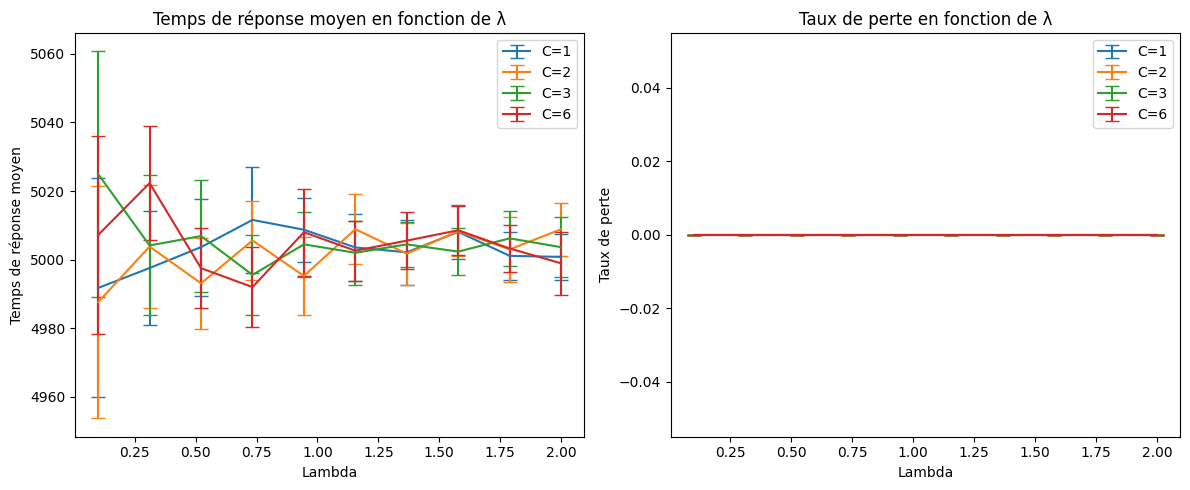

In [12]:
# Tracé des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for C in C_VALUES:
    plt.errorbar(LAMBDA_VALUES, response_times[C], yerr=response_intervals[C], label=f'C={C}', capsize=5)
plt.xlabel('Lambda')
plt.ylabel('Temps de réponse moyen')
plt.title('Temps de réponse moyen en fonction de λ')
plt.legend()

plt.subplot(1, 2, 2)
for C in C_VALUES:
    plt.errorbar(LAMBDA_VALUES, loss_rates[C], yerr=loss_intervals[C], label=f'C={C}', capsize=5)
plt.xlabel('Lambda')
plt.ylabel('Taux de perte')
plt.title('Taux de perte en fonction de λ')
plt.legend()

plt.tight_layout()
plt.show()

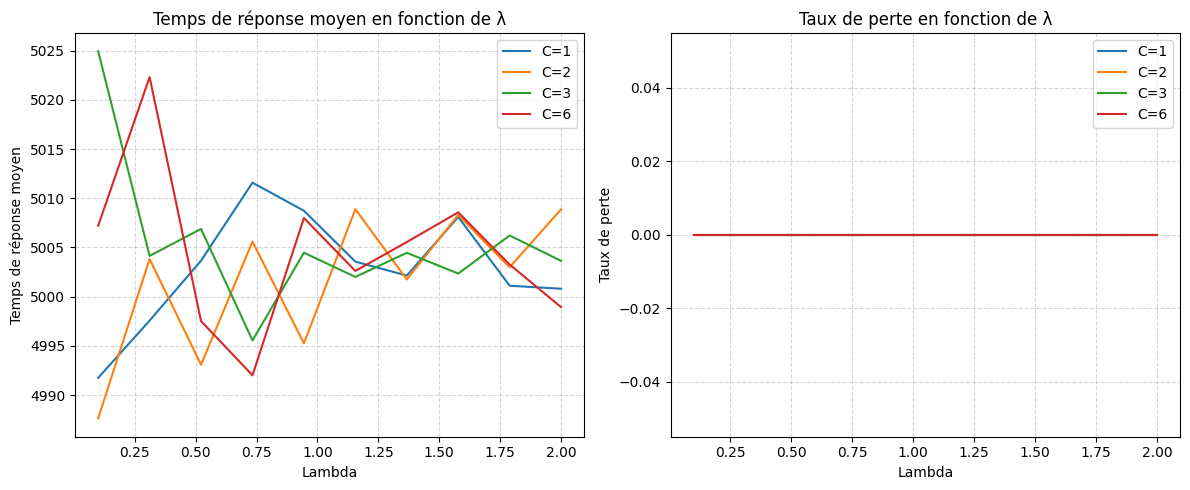

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

# 1️⃣ Temps de réponse moyen avec intervalles de confiance
plt.subplot(1, 2, 1)
for C in C_VALUES:
    sns.lineplot(x=LAMBDA_VALUES, y=response_times[C], label=f'C={C}', errorbar=('ci', 95))
plt.xlabel('Lambda')
plt.ylabel('Temps de réponse moyen')
plt.title('Temps de réponse moyen en fonction de λ')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Ajout de la grille

# 2️⃣ Taux de perte avec intervalles de confiance
plt.subplot(1, 2, 2)
for C in C_VALUES:
    sns.lineplot(x=LAMBDA_VALUES, y=loss_rates[C], label=f'C={C}', errorbar=('ci', 95))
plt.xlabel('Lambda')
plt.ylabel('Taux de perte')
plt.title('Taux de perte en fonction de λ')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Ajout de la grille

plt.tight_layout()
plt.show()
